In [1]:
import pickle
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import warnings

In [2]:
warnings.filterwarnings('ignore')

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
df_unq = pd.read_csv('../data/tcga_annotated_clean4ML.tsv.gz', sep='\t')
df_unq

CHROM        POS REF ALT    Transcript_ID                      HGVSc  \
0        1     944753   C   T  ENST00000327044  ENST00000327044:c.2191C>T   
1        1     952113   G   A  ENST00000327044  ENST00000327044:c.1218G>A   
2        1    1255304   G   T  ENST00000349431   ENST00000349431:c.679G>T   
3        1    1338573   G   T  ENST00000378888  ENST00000378888:c.1288G>T   
4        1    1387314   C   T  ENST00000400809  ENST00000400809:c.1480C>T   
...    ...        ...  ..  ..              ...                        ...   
4013     X  152920717   C   T  ENST00000370268   ENST00000370268:c.622C>T   
4014     X  153650171   G   T  ENST00000342782  ENST00000342782:c.1021G>T   
4015     X  154030948   C   T  ENST00000303391   ENST00000303391:c.880C>T   
4016     X  154354015   C   A  ENST00000369850  ENST00000369850:c.5586C>A   
4017     X  154402790   C   T  ENST00000014935   ENST00000014935:c.826C>T   

      KIM_PTC_to_start_codon  KIM_upstream_exon_count  \
0                       2193                       18   
1                       1218                       10   
2                        681                        6   
3                       1290                       11   
4                       1482                       10   
...                      ...                      ...   
4013                     624                        8   
4014                    1023                        3   
4015                     882                        3   
4016                    5586                       34   
4017                     828                        8   

      KIM_downstream_exon_count  KIM_last_exon  ...  phyloP100way_vertebrate  \
0                             0              1  ...                    1.489   
1                             8              0  ...                    7.149   
2                             0              1  ...                    7.448   
3                             3              0  ...                    7.850   
4                             0              1  ...                    0.468   
...                         ...            ...  ...                      ...   
4013                         14              0  ...                    1.169   
4014                          0              1  ...                    6.742   
4015                          0              1  ...                    3.156   
4016                         13              0  ...                   -0.708   
4017                          0              1  ...                   -2.736   

      phyloP17way_primate  phyloP470way_mammalian  phastCons100way_vertebrate  \
0                   0.654                     NaN                       0.095   
1                   0.549                     NaN                       1.000   
2                   0.599                   7.591                       1.000   
3                   0.596                   7.673                       1.000   
4                   0.656                   4.959                       0.998   
...                   ...                     ...                         ...   
4013                0.599                     NaN                       0.365   
4014                0.672                     NaN                       1.000   
4015                0.658                   5.360                       1.000   
4016               -3.409                 -10.746                       0.000   
4017                0.670                   0.017                       0.000   

      phastCons17way_primate  phastCons470way_mammalian  gnomad41_genome_AF  \
0                      0.022                      0.993            0.000000   
1                      0.961                      1.000            0.000000   
2                      0.996                      1.000            0.000000   
3                      0.061                      1.000            0.000000   
4                      0.372                      1.000           

In [4]:
def apply_baseline_rules(df, exon_len_threshold=407, penultimate_threshold=55, start_threshold=100):

    # long exon rule
    df['long_exon'] = 0
    df.loc[df['current_exon_len'] > exon_len_threshold, 'long_exon'] = 1

    # penultimate exon rule
    df['penultimate_flag'] = 0
    df.loc[
        (df['DIST_FROM_LAST_EXON'] < penultimate_threshold) &
        (df['DIST_FROM_LAST_EXON'] >= 0), 
        'penultimate_flag'
    ] = 1

    # close to start rule
    df['close_to_start'] = 0
    df.loc[df['CDS_position'] < start_threshold, 'close_to_start'] = 1

    return df


In [5]:
# last exon rule
df_unq['last_exon'] = 0
df_unq.loc[df_unq['current_exon_number']==df_unq['total_exon_numbers'], 'last_exon'] = 1

### Splits

In [6]:
test_var_ids = df_unq[df_unq['CHROM'].isin(['20', '21', '22'])]['HGVSc'].values.tolist()
test_var_ids = list(set(test_var_ids))
test_var_ids[0:5], len(test_var_ids)

(['ENST00000380266:c.1954C>T',
  'ENST00000216190:c.877G>T',
  'ENST00000377813:c.712C>T',
  'ENST00000380605:c.502C>T',
  'ENST00000359114:c.118G>T'],
 224)

In [7]:
val_var_ids = df_unq[df_unq['CHROM']=='19']['HGVSc'].values.tolist()
val_var_ids = list(set(val_var_ids))
val_var_ids[0:5], len(val_var_ids)

(['ENST00000393796:c.1103C>A',
  'ENST00000439461:c.49G>T',
  'ENST00000317683:c.62C>A',
  'ENST00000221735:c.1504C>T',
  'ENST00000264832:c.979G>T'],
 204)

In [8]:
train_var_ids = list(set(df_unq.HGVSc.values.tolist()) - set(val_var_ids) - set(test_var_ids))
train_var_ids[0:5], len(train_var_ids)

(['ENST00000261590:c.355C>T',
  'ENST00000371953:c.195C>G',
  'ENST00000285106:c.571A>T',
  'ENST00000354911:c.1375C>T',
  'ENST00000204566:c.118C>T'],
 3590)

### loaders

In [9]:
def get_X_y_splits(df, features, train_var_ids, test_var_ids, val_var_ids, target_column='NMD_efficiency'):
    """
    Splits the DataFrame into training, testing, and validation sets based on features and target column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing all data.
    - features (list): List of feature column names to use for X.
    - train_var_ids (list): List of variant IDs for training set.
    - test_var_ids (list): List of variant IDs for testing set.
    - val_var_ids (list): List of variant IDs for validation set.
    - target_column (str): Name of the target column. Default is 'NMD_efficiency'.

    Returns:
    - X_train, X_test, X_val: Feature sets for training, testing, and validation.
    - y_train, y_test, y_val: Target sets for training, testing, and validation.
    """
    # Training set
    X_train = df[df['HGVSc'].isin(train_var_ids)][features]
    y_train = df[df['HGVSc'].isin(train_var_ids)][target_column]
    
    # Testing set
    X_test = df[df['HGVSc'].isin(test_var_ids)][features]
    y_test = df[df['HGVSc'].isin(test_var_ids)][target_column]
    
    # Validation set
    X_val = df[df['HGVSc'].isin(val_var_ids)][features]
    y_val = df[df['HGVSc'].isin(val_var_ids)][target_column]
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, targets, feature_means=None, feature_stds=None):
        """
        Args:
            data (pd.DataFrame): Feature matrix with possible NaNs.
            targets (pd.Series or torch.Tensor): Target values.
            feature_means (pd.Series): Feature means calculated from the training dataset.
            feature_stds (pd.Series): Feature standard deviations from the training dataset.
        """
        if feature_means is not None:
            # Fill missing values using the training feature means
            data = data.fillna(feature_means)
        
        if feature_means is not None and feature_stds is not None:
            # Normalize using training statistics
            data = (data - feature_means) / (feature_stds + 1e-8)  # Add epsilon to prevent division by zero
        
        self.data = data.values
        self.targets = targets.values if isinstance(targets, pd.Series) else targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y


In [11]:
def create_dataloaders(X_train, y_train, X_test, y_test, X_val, y_val,  
                       batch_size=32, dataset_class=CustomDataset):

    train_feature_means= X_train.mean()
    train_feature_stds = X_train.std()

    # Create datasets
    train_dataset = dataset_class(X_train, y_train, train_feature_means, train_feature_stds)
    test_dataset = dataset_class(X_test, y_test, train_feature_means, train_feature_stds)
    val_dataset = dataset_class(X_val, y_val, train_feature_means, train_feature_stds)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, val_loader


### train MLP

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Hyperparameters
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 5e-4
HIDDEN_DIMS = [8, 8]
DROPOUT = 0.25
N_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 10
TRANSFORMATION = 'none'  # Options: 'z-score', 'min-max', 'log', 'none'

# Evaluation Metrics
def evaluate_regression_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy().flatten()
    y_pred = y_pred.cpu().numpy().flatten()
    loss = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(loss)
    r2 = r2_score(y_true, y_pred)
    
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        spearman_corr = np.nan
    else:
        try:
            spearman_corr, _ = spearmanr(y_true, y_pred)
        except ValueError:
            spearman_corr = np.nan
    
    return {
        'loss': loss,
        'spearman_corr': spearman_corr,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim, dtype=torch.float32))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1, dtype=torch.float32))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Transformation Functions
def apply_transformation(y, transformation, stats):
    if transformation == 'log':
        return torch.log1p(torch.clamp(y - stats['min'] + 1, min=1e-8))
    elif transformation == 'z-score':
        return (y - stats['mean']) / (stats['std'] + 1e-8)
    elif transformation == 'min-max':
        return (y - stats['min']) / (stats['max'] - stats['min'] + 1e-8)
    return y

def inverse_transformation(y, stats, transformation):
    if transformation == 'log':
        return torch.expm1(y) + stats['min'] - 1
    elif transformation == 'z-score':
        return y * stats['std'] + stats['mean']
    elif transformation == 'min-max':
        return y * (stats['max'] - stats['min']) + stats['min']
    return y

# Calculate Transformation Statistics
def calculate_transformation_stats(dataset, transformation):
    if transformation == 'none':
        return {}
    
    y = torch.cat([targets for _, targets in dataset], dim=0)
    stats = {}
    if transformation == 'log':
        stats['min'] = y.min()
    elif transformation == 'z-score':
        stats['mean'] = y.mean()
        stats['std'] = y.std()
    elif transformation == 'min-max':
        stats['min'] = y.min()
        stats['max'] = y.max()
    return stats

# Training Function
def train_mlp(train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = next(iter(train_loader))[0].shape[1]
    model = MLP(input_dim, HIDDEN_DIMS, DROPOUT).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Calculate global transformation stats
    transformation_stats = calculate_transformation_stats(train_loader, TRANSFORMATION)
    
    metrics = {'epoch': [], 'phase': [], 'loss': [], 'spearman_corr': [], 'mae': [], 'rmse': [], 'r2': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    best_model_state = None
    
    for epoch in range(1, N_EPOCHS + 1):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            all_preds, all_targets = [], []
            running_loss = 0.0
            
            with torch.set_grad_enabled(phase == 'train'):
                for inputs, targets in loader:
                    inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32)
                    original_targets = targets.clone()
                    
                    if TRANSFORMATION != 'none':
                        targets = apply_transformation(targets, TRANSFORMATION, transformation_stats)
                    
                    optimizer.zero_grad()
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, targets)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    all_preds.append(outputs.detach())
                    all_targets.append(original_targets.detach())
            
            epoch_loss = running_loss / len(loader.dataset)
            all_preds = torch.cat(all_preds)
            all_targets = torch.cat(all_targets)
            
            if TRANSFORMATION != 'none':
                all_preds = inverse_transformation(all_preds, transformation_stats, TRANSFORMATION)
            
            epoch_metrics = evaluate_regression_metrics(all_targets, all_preds)
            epoch_metrics['loss'] = epoch_loss
            
            # Log metrics
            metrics['epoch'].append(epoch)
            metrics['phase'].append(phase)
            for key, value in epoch_metrics.items():
                metrics[key].append(value)
            
            # Early stopping logic
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    patience_counter = 0
                    best_model_state = model.state_dict()
                else:
                    patience_counter += 1
                    if patience_counter >= EARLY_STOPPING_PATIENCE:
                        print(f"Early stopping at epoch {epoch} with best validation loss: {best_val_loss:.4f}")
                        model.load_state_dict(best_model_state)
                        metrics_df = pd.DataFrame(metrics)
                        return metrics_df, evaluate_regression_metrics(all_targets, all_preds), model
            
            # Print metrics every 5 epochs for both phases
            if epoch % 5 == 0:
                print(
                    f"[Epoch {epoch:03d}] Phase: {phase:5s} | "
                    f"Loss: {epoch_metrics['loss']:.4f} | "
                    f"Spearman: {epoch_metrics['spearman_corr']:.4f} | "
                    f"MAE: {epoch_metrics['mae']:.4f} | "
                    f"RMSE: {epoch_metrics['rmse']:.4f} | "
                    f"R²: {epoch_metrics['r2']:.4f}"
                )
    
    # Load the best model before final testing
    model.load_state_dict(best_model_state)
    
    # Final Test Evaluation
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32)
            outputs = model(inputs).squeeze()
            all_preds.append(outputs.detach())
            all_targets.append(targets.detach())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    if TRANSFORMATION != 'none':
        all_preds = inverse_transformation(all_preds, transformation_stats, TRANSFORMATION)
    
    test_metrics = evaluate_regression_metrics(all_targets, all_preds)
    print(
        "\n📊 Final Test Metrics | "
        f"Loss: {test_metrics['loss']:.4f} | "
        f"Spearman: {test_metrics['spearman_corr']:.4f} | "
        f"MAE: {test_metrics['mae']:.4f} | "
        f"RMSE: {test_metrics['rmse']:.4f} | "
        f"R²: {test_metrics['r2']:.4f}"
    )
    
    metrics_df = pd.DataFrame(metrics)
    return metrics_df, test_metrics, model


In [13]:
from itertools import product

def grid_search(df, feature_columns, train_var_ids, test_var_ids, val_var_ids, 
                exon_len_range, penultimate_range, start_range,
                exon_len_step, penultimate_step, start_step,
                baseline_features):
    """
    Perform a grid search to find the best parameters for exon_len_threshold, 
    penultimate_threshold, and start_threshold.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - feature_columns (list): List of features to keep in the DataFrame.
    - train_var_ids, test_var_ids, val_var_ids (list): Lists of variant IDs for splitting.
    - exon_len_range (tuple): Range of values for exon_len_threshold (start, end).
    - penultimate_range (tuple): Range of values for penultimate_threshold (start, end).
    - start_range (tuple): Range of values for start_threshold (start, end).
    - baseline_features (list): List of baseline features for `get_X_y_splits`.

    Returns:
    - results_df (pd.DataFrame): DataFrame with results for each parameter combination.
    - best_params (dict): Best parameter combination.
    """
    results = []

    # Define the parameter grid
    exon_len_values = range(exon_len_range[0], exon_len_range[1] + 1, exon_len_step)
    penultimate_values = range(penultimate_range[0], penultimate_range[1] + 1, penultimate_step)
    start_values = range(start_range[0], start_range[1] + 1, start_step)
    
    # Iterate over all combinations
    for exon_len_threshold, penultimate_threshold, start_threshold in product(
        exon_len_values, penultimate_values, start_values
    ):
        # Apply rules with current parameters
        df_temp = apply_baseline_rules(
            df[feature_columns].copy(), 
            exon_len_threshold=exon_len_threshold, 
            penultimate_threshold=penultimate_threshold, 
            start_threshold=start_threshold
        )
        
        # Split data
        X_train, X_test, X_val, y_train, y_test, y_val = get_X_y_splits(
            df_temp, baseline_features, train_var_ids, test_var_ids, val_var_ids
        )
        
        # Create dataloaders
        train_loader, test_loader, val_loader = create_dataloaders(
            X_train, y_train, X_test, y_test, X_val, y_val
        )

        seed_everything(1234)

        print(f'exon_len_threshold: {exon_len_threshold}, \npenultimate_threshold: {penultimate_threshold}, \nstart_threshold: {start_threshold}')
        # Train the model
        metrics_df, val_metrics, model = train_mlp(train_loader, val_loader, val_loader)
        
        # Save results
        results.append({
            'exon_len_threshold': exon_len_threshold,
            'penultimate_threshold': penultimate_threshold,
            'start_threshold': start_threshold,
            'val_loss': val_metrics['loss'],
            'val_spearman_corr': val_metrics['spearman_corr'],
            'val_mae': val_metrics['mae'],
            'val_rmse': val_metrics['rmse'],
            'val_r2': val_metrics['r2']
        })
        
    # Create a DataFrame with all results
    results_df = pd.DataFrame(results)
    
    # Find the best parameters (lowest validation loss)
    best_idx = results_df['val_loss'].idxmin()
    best_params = results_df.loc[best_idx].to_dict()
    
    return results_df, best_params


In [ ]:
keep_cols = ['current_exon_len', 'DIST_FROM_LAST_EXON', 'CDS_position', 'last_exon', 'NMD_efficiency', 'HGVSc']
baseline_features = ['last_exon', 'long_exon', 'penultimate_flag', 'close_to_start']

In [14]:
# take large steps

# Define ranges and steps for parameters
exon_len_range = (350, 450)  # Start and end
penultimate_range = (25, 75)
start_range = (50, 250)

exon_len_step = 25  # Step size for exon_len_range
penultimate_step = 5  # Step size for penultimate_range
start_step = 25  # Step size for start_range

# Run grid search
results_df, best_params = grid_search(
    df_unq, keep_cols, train_var_ids, test_var_ids, val_var_ids, 
    exon_len_range, penultimate_range, start_range, 
    exon_len_step, penultimate_step, start_step, 
    baseline_features
)

results_df.to_csv("../res/grid_search/grid_search_results_largesteps.csv", index=False)

exon_len_threshold: 350, 
penultimate_threshold: 25, 
start_threshold: 50
[Epoch 005] Phase: train | Loss: 1.3621 | Spearman: 0.4357 | MAE: 0.9057 | RMSE: 1.1671 | R²: 0.1363
[Epoch 005] Phase: val   | Loss: 1.1169 | Spearman: 0.6430 | MAE: 0.8061 | RMSE: 1.0568 | R²: 0.3160
[Epoch 010] Phase: train | Loss: 1.3008 | Spearman: 0.4720 | MAE: 0.8738 | RMSE: 1.1405 | R²: 0.1752
[Epoch 010] Phase: val   | Loss: 1.0800 | Spearman: 0.6485 | MAE: 0.7931 | RMSE: 1.0392 | R²: 0.3386
[Epoch 015] Phase: train | Loss: 1.2484 | Spearman: 0.4842 | MAE: 0.8577 | RMSE: 1.1173 | R²: 0.2084
[Epoch 015] Phase: val   | Loss: 1.0758 | Spearman: 0.6482 | MAE: 0.7957 | RMSE: 1.0372 | R²: 0.3411
[Epoch 020] Phase: train | Loss: 1.2334 | Spearman: 0.4879 | MAE: 0.8581 | RMSE: 1.1106 | R²: 0.2179
[Epoch 020] Phase: val   | Loss: 1.0786 | Spearman: 0.6484 | MAE: 0.8009 | RMSE: 1.0385 | R²: 0.3395
[Epoch 025] Phase: train | Loss: 1.2467 | Spearman: 0.4707 | MAE: 0.8652 | RMSE: 1.1165 | R²: 0.2095
Early stopping at

In [17]:
best_params

{'exon_len_threshold': 375.0,
 'penultimate_threshold': 45.0,
 'start_threshold': 100.0,
 'val_loss': 0.9874094128608704,
 'val_spearman_corr': 0.7033884527488031,
 'val_mae': 0.7652919888496399,
 'val_rmse': 0.9936847686767578,
 'val_r2': 0.395308256149292}

In [18]:
# take small steps around best_params

# Define ranges and steps for parameters
exon_len_range = (350, 400)  # Start and end
penultimate_range = (40, 50)
start_range = (75, 125)

exon_len_step = 5  # Step size for exon_len_range
penultimate_step = 1  # Step size for penultimate_range
start_step = 5  # Step size for start_range

# Run grid search
results_df2, best_params2 = grid_search(
    df_unq, keep_cols, train_var_ids, test_var_ids, val_var_ids, 
    exon_len_range, penultimate_range, start_range, 
    exon_len_step, penultimate_step, start_step, 
    baseline_features
)

results_df2.to_csv("../res/grid_search/grid_search_results_smallsteps.csv", index=False)

exon_len_threshold: 350, 
penultimate_threshold: 40, 
start_threshold: 75
[Epoch 005] Phase: train | Loss: 1.3328 | Spearman: 0.4622 | MAE: 0.8928 | RMSE: 1.1545 | R²: 0.1549
[Epoch 005] Phase: val   | Loss: 1.0645 | Spearman: 0.6805 | MAE: 0.7852 | RMSE: 1.0318 | R²: 0.3481
[Epoch 010] Phase: train | Loss: 1.2632 | Spearman: 0.5058 | MAE: 0.8574 | RMSE: 1.1239 | R²: 0.1990
[Epoch 010] Phase: val   | Loss: 1.0217 | Spearman: 0.6856 | MAE: 0.7692 | RMSE: 1.0108 | R²: 0.3743
[Epoch 015] Phase: train | Loss: 1.2096 | Spearman: 0.5179 | MAE: 0.8411 | RMSE: 1.0998 | R²: 0.2330
[Epoch 015] Phase: val   | Loss: 1.0170 | Spearman: 0.6860 | MAE: 0.7719 | RMSE: 1.0085 | R²: 0.3772
[Epoch 020] Phase: train | Loss: 1.2038 | Spearman: 0.5161 | MAE: 0.8447 | RMSE: 1.0972 | R²: 0.2367
[Epoch 020] Phase: val   | Loss: 1.0211 | Spearman: 0.6850 | MAE: 0.7770 | RMSE: 1.0105 | R²: 0.3747
[Epoch 025] Phase: train | Loss: 1.2086 | Spearman: 0.5065 | MAE: 0.8488 | RMSE: 1.0994 | R²: 0.2336
Early stopping at

In [19]:
best_params2

{'exon_len_threshold': 355.0,
 'penultimate_threshold': 49.0,
 'start_threshold': 120.0,
 'val_loss': 0.9623152613639832,
 'val_spearman_corr': 0.7114311982419579,
 'val_mae': 0.7533628940582275,
 'val_rmse': 0.9809767007827759,
 'val_r2': 0.41067594289779663}

### Visualization

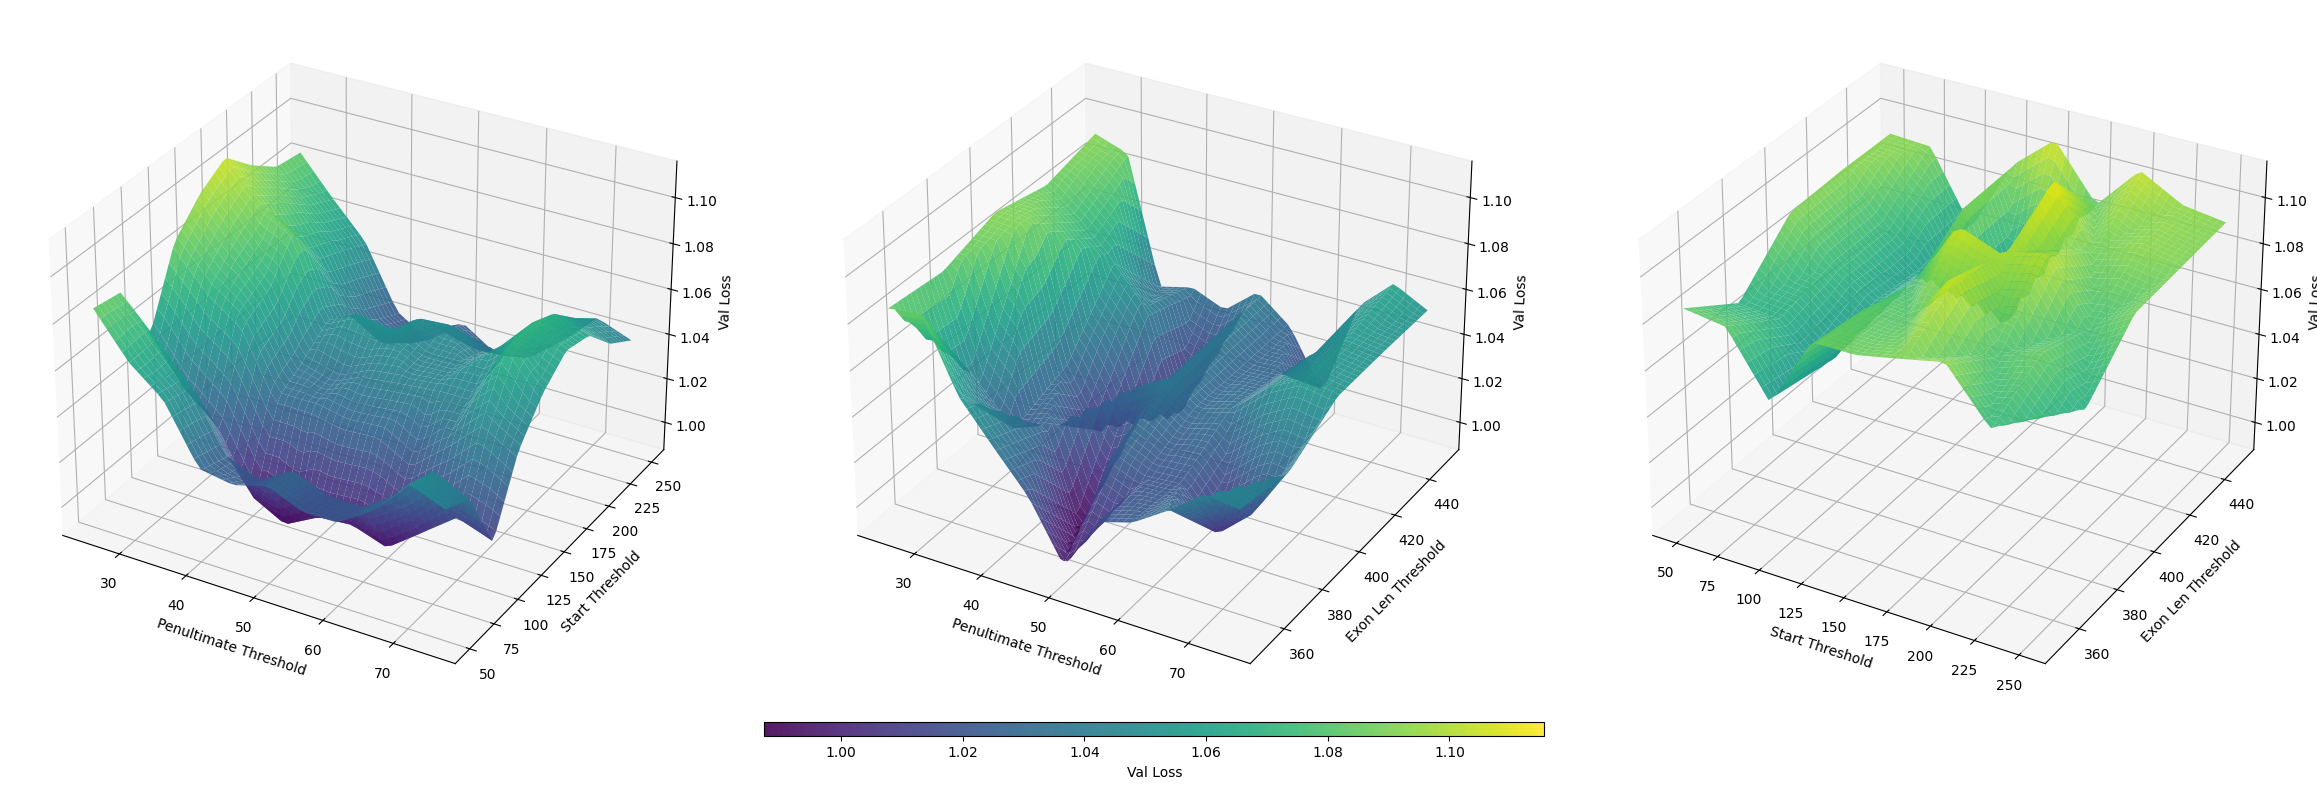

In [107]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import gridspec

# Extract data
z_variable = 'val_loss'
z_variable2 = z_variable.replace("_", " ").title()
x1, y1, z1 = results_df['penultimate_threshold'], results_df['start_threshold'], results_df[z_variable]
x2, y2, z2 = results_df['penultimate_threshold'], results_df['exon_len_threshold'], results_df[z_variable]
x3, y3, z3 = results_df['start_threshold'], results_df['exon_len_threshold'], results_df[z_variable]

# Global z range
z_min, z_max = results_df[z_variable].min(), results_df[z_variable].max()

# Create a shared normalization for the color scale
norm = Normalize(vmin=z_min, vmax=z_max)
cmap = 'viridis'

# Function to interpolate data and create a grid
def interpolate_surface(x, y, z):
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='linear')
    return xi, yi, zi

# Interpolate surfaces
x1i, y1i, z1i = interpolate_surface(x1, y1, z1)
x2i, y2i, z2i = interpolate_surface(x2, y2, z2)
x3i, y3i, z3i = interpolate_surface(x3, y3, z3)

# Create the figure
fig = plt.figure(figsize=(24, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[25, 0.5])  # Adjust grid size for colorbar placement

# Plot 1: Penultimate vs Start vs Val MAE
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
surface1 = ax1.plot_surface(x1i, y1i, z1i, cmap=cmap, norm=norm, edgecolor='none', alpha=0.9)
ax1.set_xlabel('Penultimate Threshold')
ax1.set_ylabel('Start Threshold')
ax1.set_zlabel(f'{z_variable2}')
ax1.set_zlim(z_min, z_max)

# Plot 2: Penultimate vs Exon Len vs Val MAE
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
surface2 = ax2.plot_surface(x2i, y2i, z2i, cmap=cmap, norm=norm, edgecolor='none', alpha=0.9)
ax2.set_xlabel('Penultimate Threshold')
ax2.set_ylabel('Exon Len Threshold')
ax2.set_zlabel(f'{z_variable2}')
ax2.set_zlim(z_min, z_max)

# Plot 3: Start vs Exon Len vs Val MAE
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
surface3 = ax3.plot_surface(x3i, y3i, z3i, cmap=cmap, norm=norm, edgecolor='none', alpha=0.9)
ax3.set_xlabel('Start Threshold')
ax3.set_ylabel('Exon Len Threshold')
ax3.set_zlabel(f'{z_variable2}')
ax3.set_zlim(z_min, z_max)

# Add a custom colorbar below the plots
cax = fig.add_subplot(gs[1, 1])  # Full-width colorbar at the bottom
cbar = fig.colorbar(surface1, cax=cax, orientation='horizontal')
cbar.set_label(f'{z_variable2}')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('../res/plots/grid_search_bigstep.png', dpi=300)
plt.show()


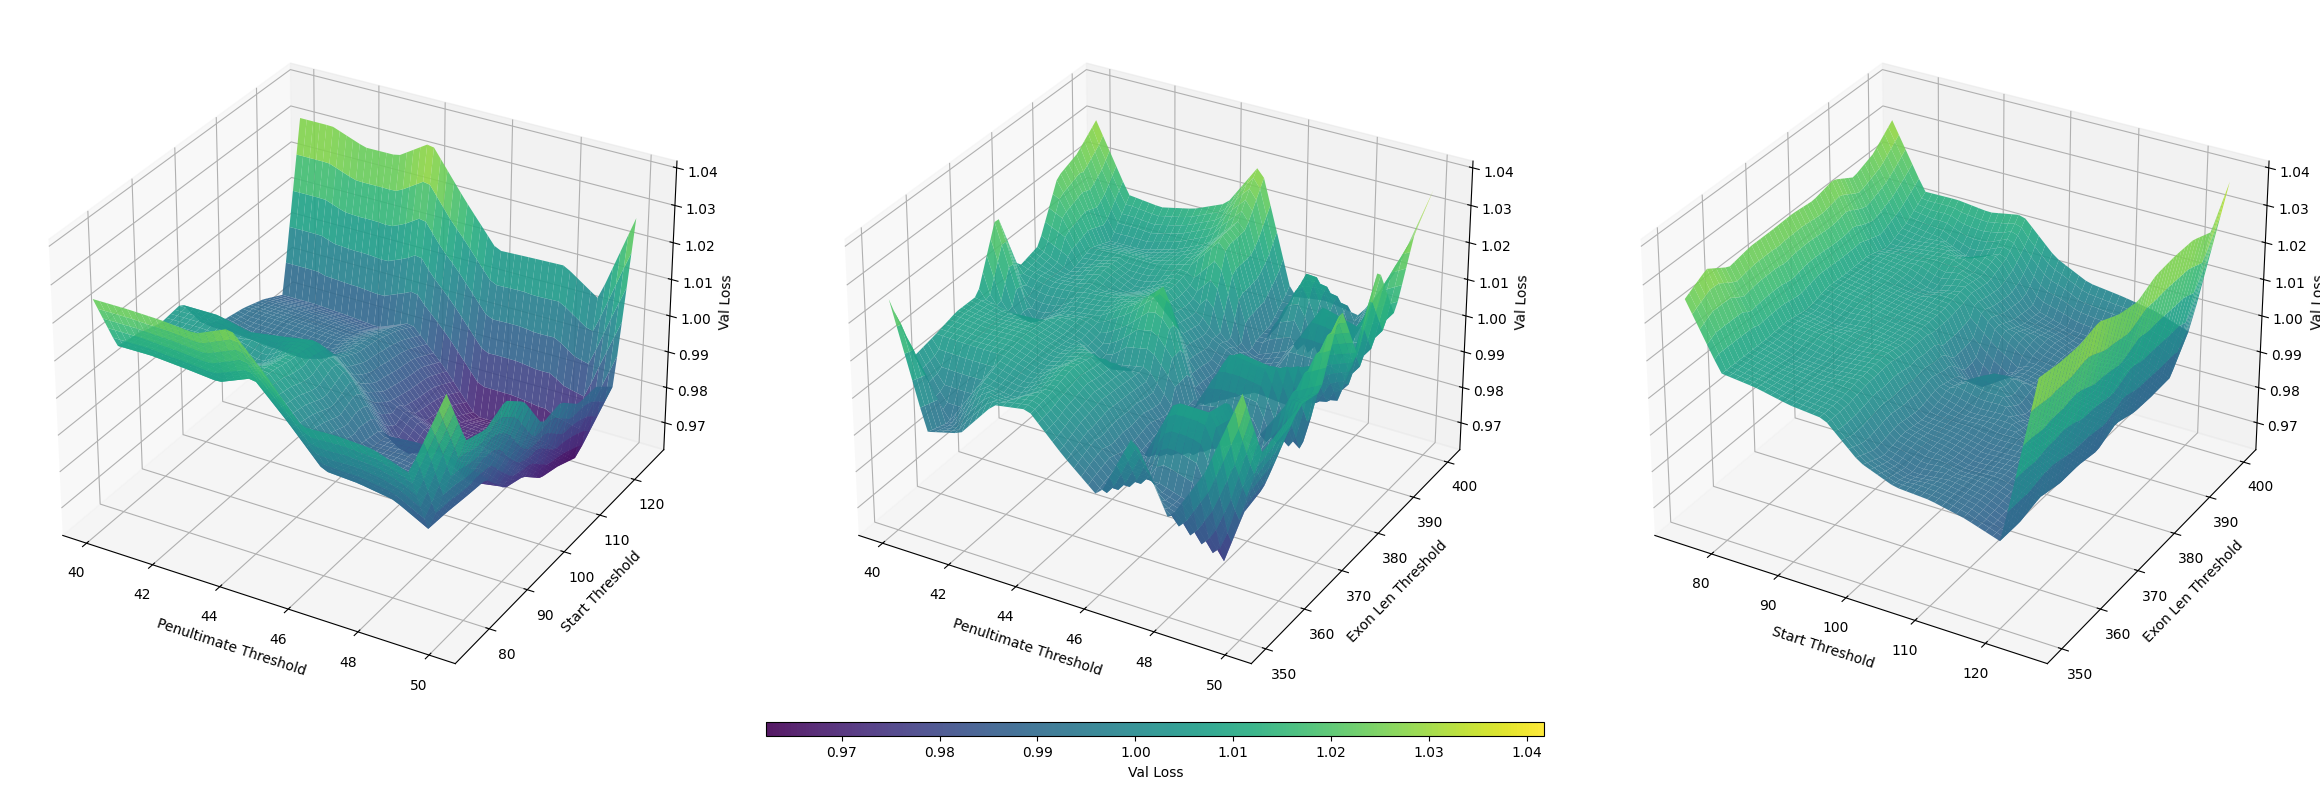

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import gridspec

# Extract data
z_variable = 'val_loss'
z_variable2 = z_variable.replace("_", " ").title()
x1, y1, z1 = results_df2['penultimate_threshold'], results_df2['start_threshold'], results_df2[z_variable]
x2, y2, z2 = results_df2['penultimate_threshold'], results_df2['exon_len_threshold'], results_df2[z_variable]
x3, y3, z3 = results_df2['start_threshold'], results_df2['exon_len_threshold'], results_df2[z_variable]

# Global z range
z_min, z_max = results_df2[z_variable].min(), results_df2[z_variable].max()

# Create a shared normalization for the color scale
norm = Normalize(vmin=z_min, vmax=z_max)
cmap = 'viridis'

# Function to interpolate data and create a grid
def interpolate_surface(x, y, z):
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='linear')
    return xi, yi, zi

# Interpolate surfaces
x1i, y1i, z1i = interpolate_surface(x1, y1, z1)
x2i, y2i, z2i = interpolate_surface(x2, y2, z2)
x3i, y3i, z3i = interpolate_surface(x3, y3, z3)

# Create the figure
fig = plt.figure(figsize=(24, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[25, 0.5])  # Adjust grid size for colorbar placement

# Plot 1: Penultimate vs Start vs Val MAE
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
surface1 = ax1.plot_surface(x1i, y1i, z1i, cmap=cmap, norm=norm, edgecolor='none', alpha=0.9)
ax1.set_xlabel('Penultimate Threshold')
ax1.set_ylabel('Start Threshold')
ax1.set_zlabel(f'{z_variable2}')
ax1.set_zlim(z_min, z_max)

# Plot 2: Penultimate vs Exon Len vs Val MAE
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
surface2 = ax2.plot_surface(x2i, y2i, z2i, cmap=cmap, norm=norm, edgecolor='none', alpha=0.9)
ax2.set_xlabel('Penultimate Threshold')
ax2.set_ylabel('Exon Len Threshold')
ax2.set_zlabel(f'{z_variable2}')
ax2.set_zlim(z_min, z_max)

# Plot 3: Start vs Exon Len vs Val MAE
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
surface3 = ax3.plot_surface(x3i, y3i, z3i, cmap=cmap, norm=norm, edgecolor='none', alpha=0.9)
ax3.set_xlabel('Start Threshold')
ax3.set_ylabel('Exon Len Threshold')
ax3.set_zlabel(f'{z_variable2}')
ax3.set_zlim(z_min, z_max)

# Add a custom colorbar below the plots
cax = fig.add_subplot(gs[1, 1])  # Full-width colorbar at the bottom
cbar = fig.colorbar(surface1, cax=cax, orientation='horizontal')
cbar.set_label(f'{z_variable2}')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('../res/plots/grid_search_smallstep.png', dpi=300)
plt.show()
